In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageTk
import cv2
import keras_ocr
from scipy.spatial.distance import cdist
import tkinter as tk
from tkinter import simpledialog, messagebox

C:\Users\benst\AppData\Local\Temp\ipykernel_13248\293037191.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## get bounds and scale of efficiency map and scale

- cropper and boundary marker function

In [2]:
def crop_image_with_points(image_path):
    class ImageCropper:
        def __init__(self, image_path):
            self.image_path = image_path
            self.points = []
            self.bottom_left = None
            self.top_right = None

        def get_values(self):
            value = simpledialog.askstring("Input", "Enter values (x_min, x_max, y_min, y_max) separated by spaces:")
            try:
                x_min, x_max, y_min, y_max = map(int, value.split())
                x_max += 1  # increment to include the last pixel
                y_max += 1  # increment to include the last pixel
                return {'x_min': x_min, 'x_max': x_max, 'y_min': y_min, 'y_max': y_max}
            except ValueError:
                messagebox.showerror("Error", "Invalid input. Please enter four integer values separated by spaces.")
                return self.get_values()

        def select_points(self, event, x, y, flags, param):
            
            if event == cv2.EVENT_LBUTTONDOWN:
                if len(self.points) < 2:
                    self.points.append((x, y))
                    cv2.circle(self.image, (x, y), 5, (0, 255, 0), -1)
                    cv2.imshow('Select Points', self.image)
                    if len(self.points) == 2:
                        self.bottom_left = (min(self.points[0][0], self.points[1][0]), min(self.points[0][1], self.points[1][1]))
                        self.top_right = (max(self.points[0][0], self.points[1][0]), max(self.points[0][1], self.points[1][1]))

        def crop_image(self):
            if len(self.points) == 2:
                cropped_image = self.image[self.bottom_left[1]:self.top_right[1], self.bottom_left[0]:self.top_right[0]]
                cv2.imshow('Cropped Image', cropped_image)
                return cropped_image
            else:
                messagebox.showerror("Error", "Please select 2 points.")
                return None

        def run(self):
            self.image = cv2.imread(self.image_path)
            cv2.imshow('Select Points', self.image)
            messagebox.showinfo("Instruction", "Please select the bottom left and top right corners of the cropping rectangle using the mouse pointer then press 'c'.")
            cv2.setMouseCallback('Select Points', self.select_points)

            while True:
                key = cv2.waitKey(1) & 0xFF
                if key == ord('c'):
                    cropped_image = self.crop_image()
                    if cropped_image is not None:
                        return cropped_image, self.get_values()
                elif key == ord('q'):
                    break

            cv2.destroyAllWindows()
            return None, None

    # Create an ImageCropper instance
    cropper = ImageCropper(image_path)

    # Run the cropper
    cropped_image, values = cropper.run()

    cv2.destroyAllWindows()

    return cropped_image, values

In [3]:
def get_efficiency_map_bounds(ID):
    image_path = os.path.join('inputs\images', ID +'.png')
    em_img, em_boundaries_dict = crop_image_with_points(image_path)

    return em_img, em_boundaries_dict

In [4]:
def get_scale_bounds(ID):
    image_path = os.path.join('inputs\images', ID +'.png')
    sc_img, sc_boundaries_dict = crop_image_with_points(image_path)

    return sc_img, sc_boundaries_dict

## define ROI
- user marks region of interest (ROI) for the heatmap data
- region outside of this is set to black

In [5]:
def define_roi(im):
    drawing = False  
    points = []  

    def draw_boundary(event, x, y, flags, param):
        nonlocal drawing, points

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            points = [(x, y)]

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                points.append((x, y))

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            points.append((x, y))

    #image = cv2.imread(os.path.join('inputs\efficiency_maps', ID +'.png'))
    image = im
    result = image.copy()  # Create a copy of the image for drawing purposes
    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', draw_boundary)

    messagebox.showinfo("Instruction", "Please draw the region of interest of the efficiency map using the mouse pointer then press 'q'.")

    while True:
        for i in range(1, len(points)):
            cv2.line(result, points[i - 1], points[i], (0, 0, 255), 2)
        cv2.imshow('Image', result)

        key = cv2.waitKey(1) & 0xFF

        # Reset the image if 'r' is pressed
        if key == ord('r'):
            result = image.copy()
            points = []

        # Break the loop if 'q' is pressed
        elif key == ord('q'):
            break

    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(points)], (255, 255, 255))
    
    cv2.destroyAllWindows()

    return mask

## get scale
- scale a one pixel width copy of the scale image by the range of efficiencies
- if rgb's span multiple efficiencies (assumtpion they will no be separated by much) then take the mean efficiency over the rgb's
- get distinct grayscale value of the scale

In [6]:
def get_scale(im, sc_boundaries_dict):
    scale_image = im
    gs_scale_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    grayscale_array = np.array(gs_scale_image)
    array = np.array([x[0] for x in grayscale_array])
    seen = set()
    grayscale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            grayscale.append(i)

    scale = np.array(scale_image)
    scale = scale[:,0,:3]

    su = sc_boundaries_dict['x_max']
    sl = sc_boundaries_dict['x_min']
    scale_range = su - sl

    scale_items = scale.shape[0]
    scale_fidelity = scale_range / scale_items
    z_values = (np.arange(1, scale_items + 1) * scale_fidelity) + sl
    z_values = z_values[::-1] # invert as is from large to small in scale
    z_values_df = pd.DataFrame(z_values, columns=['z'])
    scale_df = pd.DataFrame(scale, columns=['r', 'g', 'b'])
    scale_df = scale_df.join(z_values_df)
    scale_df = (scale_df.groupby(['r','g','b']).agg(z_mean=('z', 'mean'))).reset_index()
    scale = scale_df.values.astype(np.uint8)

    return scale, grayscale

## get efficiency map

#### infill text
- read cropped efficiency map image 
- use a bounding box ocr to identify text
- inpaint these regions

In [7]:
# infill text using ocr

def infill_text(img):

    def midpoint(x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

    pipeline = keras_ocr.pipeline.Pipeline()

    #img = keras_ocr.tools.read(os.path.join('inputs\efficiency_maps', ID +'.png'))

    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                    
    return(img)

In [8]:
def gaussian_blur(im):
    import cv2

    blurred = cv2.GaussianBlur(im, (5, 5), 0)

    return blurred

#### infill lines and egdes
- convert image output to grayscale
- Use Canny edge detection to identify edges
- inpaint these extended by a region

In [9]:
def infill_lines(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150)

    # Create a mask by dilating the edges
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(edges, kernel, iterations=1)

    nolines = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    return nolines

#### infill not in scale
- infill regions where the pixel values are not in the scale (or white)

In [10]:
def infill_not_in_scale(im, grayscale):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _white = [255] # these are black and close to black
    in_grayscale = grayscale + _white

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in in_grayscale:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inscale

In [11]:
def apply_roi(im, mask_roi):
    im[mask_roi == 0] = [0, 0, 0]

    return im

## make efficiency lookup
- map the efficiency map image dimensions to the speed/torque dimensions from metadata
- map rbg's to efficiencies from the scale data
- produce speed, torque, efficiency mapping for pixels that are in the scale and output to csv

In [12]:
def efficiency_lookup(im, scale, em_boundaries_dict):
    x_rl = em_boundaries_dict['x_max']
    x_ll = em_boundaries_dict['x_min']
    max_xi = im.shape[1] - 1

    y_lu = em_boundaries_dict['y_max']
    y_ll = em_boundaries_dict['y_min']
    max_yi = im.shape[0] - 1

    x = []
    y = []
    z = []

    def find_closest_rgb(pixel, scale):
        if not np.all(pixel == [0, 0, 0]):
            distances = cdist([pixel], scale[:,:3])
            closest_index = np.argmin(distances)
            zval = scale[closest_index][3]
        else:
            zval = 0
        return zval

    for xi in range(im.shape[1]):
        for yi in range(im.shape[0]):
            xbar = ((x_rl - x_ll) * xi) / max_xi
            ybar = ((y_lu - y_ll) * (max_yi - yi)) / max_yi
            zi = find_closest_rgb(im[yi, xi], scale)
            x.append(xbar)
            y.append(ybar)
            z.append(zi)

    efficiency_lookup_df = pd.DataFrame(zip(x,y,z),columns=(['speed','torque','efficiency']))

    return efficiency_lookup_df

## display the processed efficiency map lookup as a heatmap

In [13]:
def efficiency_heatmap(efficiency_lookup_df, sc_boundaries_dict):
    heatmap_data = efficiency_lookup_df.pivot_table(index='torque', columns='speed', values='efficiency')
    heatmap_data = heatmap_data.iloc[::-1]

    vmin = sc_boundaries_dict['x_min']
    vmax = sc_boundaries_dict['x_max']

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title('Efficiency Heatmap')
    plt.xlabel('Speed')
    plt.ylabel('Torque')
    plt.show()

## write efficiency map lookup to csv

In [14]:
def output_efficienct_map_lookup(ID, df):
    df.to_csv('outputs\efficiency_map_lookup_'+ ID +'.csv')

## main

In [20]:
#ID = 'HDSRM300'
ID = 'YASA_P400'
#ID = '180-100-009'

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


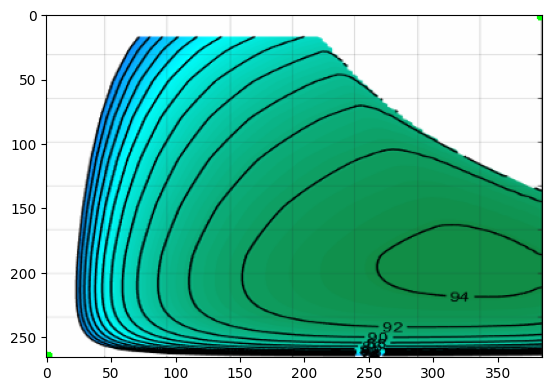

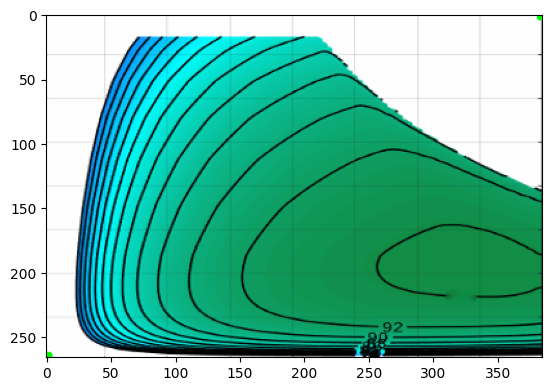

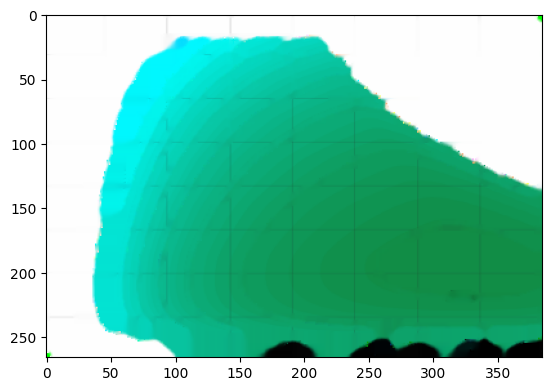

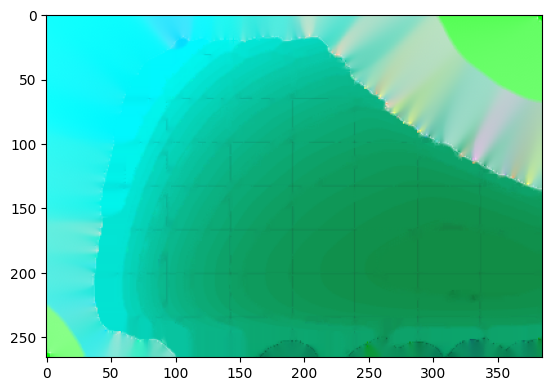

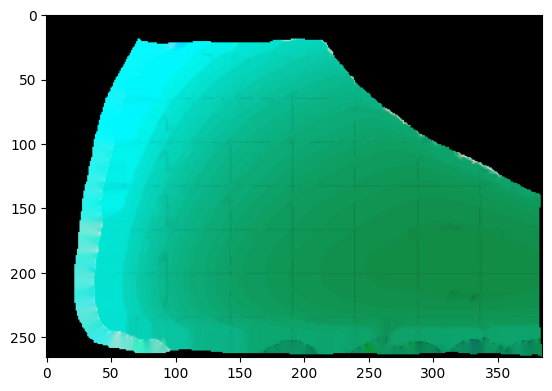

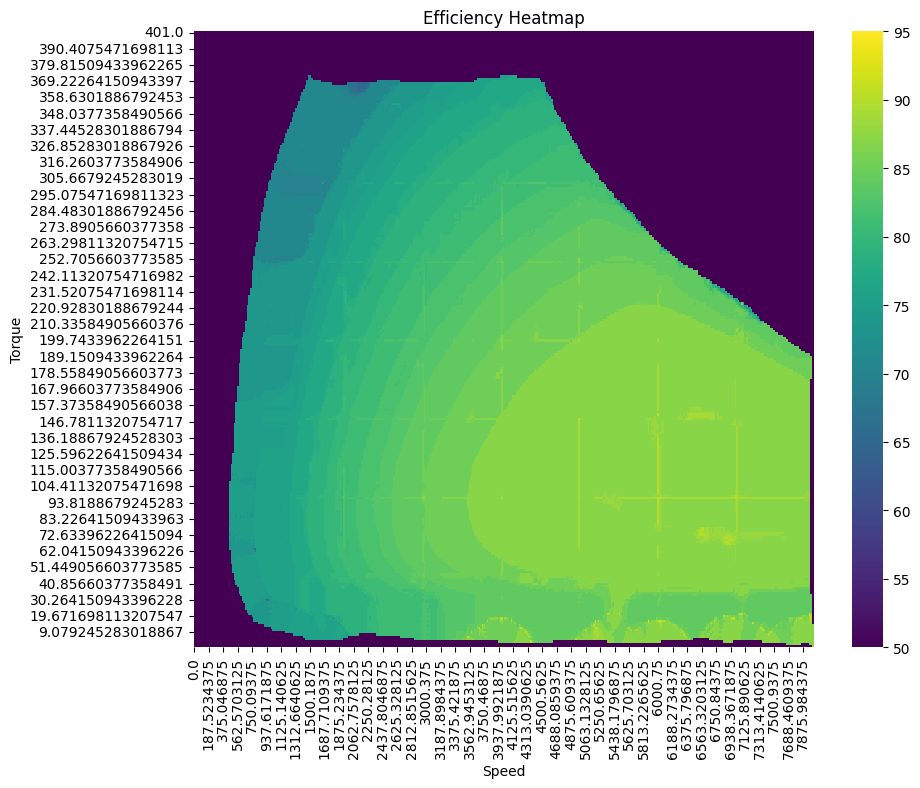

In [21]:
em_img, em_boundaries_dict = get_efficiency_map_bounds(ID)
plt.imshow(em_img)
sc_img, sc_boundaries_dict = get_scale_bounds(ID)
mask_roi = define_roi(em_img)
scale, grayscale = get_scale(sc_img, sc_boundaries_dict)
em = infill_text(em_img)
plt.show()
plt.imshow(em)
nolines = infill_lines(em)
plt.show()
plt.imshow(nolines)
inscale = infill_not_in_scale(nolines, grayscale)
plt.show()
plt.imshow(inscale)
roi = apply_roi(inscale, mask_roi)
plt.show()
plt.imshow(roi)
efficiency_lookup_df = efficiency_lookup(roi, scale, em_boundaries_dict)
efficiency_heatmap(efficiency_lookup_df, sc_boundaries_dict)
output_efficienct_map_lookup(ID, efficiency_lookup_df)

In [202]:
#TODO assumes vertical scale bar (add option to rotate)
#TODO cropper class shared amoungst efficiency map and scale use cases could have differing functionality for each
#TODO rewrite to remove for loops, add vectorisation
#TODO consider dynamic naming of axis throughout, no reason why it has to be speed, torque etc